# Avoiding catastrophic interference using Elastic Weight Consolidation (EWC)

The test is performed on MNIST data.

In [1]:
import os
# Disable GPU in a case of kernel freezing
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import utils
from keras import regularizers
from keras.optimizers import SGD
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import toimage
%matplotlib inline 
#import PIL.Image as pil
from progressbar import ProgressBar  # pip install progressbar33
from keras import optimizers
#from keras.callbacks import EarlyStopping
#from scipy.special import expit
#import pickle

Using TensorFlow backend.


In [3]:
num_epoch = 20 # number of epochs
num_neur = 400 # number of neurons in hidden layers
num_class = 10 # number of classes
img_line = 784 # input dimension
bsize = 32 # batch size

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
nb_samp = 60000 # total number of samples
nb_val = 10000 # number of validation samples
X_train = X_train.reshape(nb_samp, img_line)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.reshape(10000, img_line)
X_test = X_test.astype('float32')
X_test /= 255

Y_train = utils.to_categorical(y_train, 10)
Y_test = utils.to_categorical(y_test, 10)

model = Sequential()
l2 = 1e-4 # L2 regularization
model.add(Dense(num_neur, input_dim=img_line, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_neur, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_class, activation="softmax",kernel_regularizer=regularizers.l2(l2)))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

## Training network  on data A

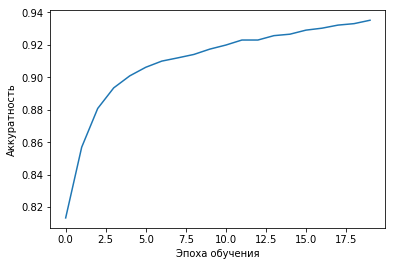

In [6]:
order_all = np.random.permutation(img_line)
tr_a = X_train[:,order_all] # permute pixels in the images
ts_a = X_test[:,order_all]

score_a = np.zeros((num_epoch*3,2))
history = model.fit(tr_a, Y_train, batch_size=bsize, epochs=num_epoch, validation_data=(ts_a,Y_test), verbose=0)
score_a[:num_epoch,0] = range(num_epoch)
score_a[:num_epoch,1] = history.history['val_acc']

plt.plot(score_a[:num_epoch,0],score_a[:num_epoch,1])
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.show()

## Calculate Fisher information

In [7]:
Fisher = 0 # diagonal of Hessian
weights = model.trainable_weights # weight tensors
input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
gradients = model.optimizer.get_gradients(model.total_loss, weights) # gradient tensors
get_gradients = K.function(inputs=input_tensors, outputs=gradients)
print('Calculating Hessian...', flush=True)
pbar = ProgressBar(maxval=nb_val).start()
for i in range(nb_val): # loop over all validation images
    val_sample = tr_a[nb_samp-nb_val+i:nb_samp-nb_val+i+1,:] # get one validation image
    y = Y_train[nb_samp-nb_val+i:nb_samp-nb_val+i+1,:] # get corresponding target
    inputs = [val_sample, [1], y, 0]
    grads = get_gradients(inputs)
    Fisher += np.square(grads)
    pbar.update(i+1)
pbar.finish()
Fisher = Fisher/nb_val

Calculating Hessian...


100% |########################################################################|


## Training network on data B

Save optimal weights for furher EWC training

In [8]:
# Get weights matrices of trained network
w_star_l0 = model.layers[0].get_weights()[0] # learned weights of layer #0
b_star_l0 = model.layers[0].get_weights()[1] # learned biases of layer #0
w_star_l1 = model.layers[1].get_weights()[0] # learned weights of layer #1
b_star_l1 = model.layers[1].get_weights()[1] # learned biases of layer #1
w_star_l2 = model.layers[2].get_weights()[0] # learned weights of layer #2
b_star_l2 = model.layers[2].get_weights()[1] # learned biases of layer #2

Define EWC regularization $\sum_i F_i\cdot(\theta_i-\theta_i^*)^2$ for every weights matrix and biases

In [9]:
lam = 150 # importance of old task

def reg_w_l0(weight_matrix): # regularization for weights in layer #0
    return (lam/2) * K.sum(K.square(weight_matrix-w_star_l0)*Fisher[0])
def reg_b_l0(weight_matrix): # regularization for biases in layer #0
    return (lam/2) * K.sum(K.square(weight_matrix-b_star_l0)*Fisher[1])
def reg_w_l1(weight_matrix): # regularization for weights in layer #1
    return (lam/2) * K.sum(K.square(weight_matrix-w_star_l1)*Fisher[2])
def reg_b_l1(weight_matrix): # regularization for biases in layer #1
    return (lam/2) * K.sum(K.square(weight_matrix-b_star_l1)*Fisher[3])
def reg_w_l2(weight_matrix): # regularization for weights in layer #2
    return (lam/2) * K.sum(K.square(weight_matrix-w_star_l2)*Fisher[4])
def reg_b_l2(weight_matrix): # regularization for biases in layer #2
    return (lam/2) * K.sum(K.square(weight_matrix-b_star_l2)*Fisher[5])

Define initializers to start from previously learned weights

In [10]:
def init_w_l0(shape, dtype=None): # initialize weights of layer #0
    return w_star_l0
def init_b_l0(shape, dtype=None): # initialize biases of layer #0
    return b_star_l0
def init_w_l1(shape, dtype=None): # initialize weights of layer #1
    return w_star_l1
def init_b_l1(shape, dtype=None): # initialize biases of layer #1
    return b_star_l1
def init_w_l2(shape, dtype=None): # initialize weights of layer #2
    return w_star_l2
def init_b_l2(shape, dtype=None): # initialize biases of layer #2
    return b_star_l2

Define new network for training on dataset B with EWC regularization 

In [11]:
model = Sequential()
model.add(Dense(num_neur, input_dim=img_line, activation="relu",
                kernel_initializer=init_w_l0,bias_initializer=init_b_l0,
                kernel_regularizer=reg_w_l0,bias_regularizer=reg_b_l0))
model.add(Dense(num_neur, activation="relu",
                kernel_initializer=init_w_l1,bias_initializer=init_b_l1,
                kernel_regularizer=reg_w_l1,bias_regularizer=reg_b_l1))
model.add(Dense(num_class, activation="softmax",
                kernel_initializer=init_w_l2,bias_initializer=init_b_l2,
                kernel_regularizer=reg_w_l2,bias_regularizer=reg_b_l2))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

Train network on data B

100% |########################################################################|


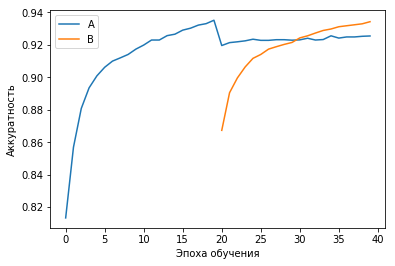

In [12]:
order_all = np.random.permutation(img_line)
tr_b = X_train[:,order_all]
ts_b = X_test[:,order_all]

score_b = np.zeros((num_epoch*2,2))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_b, Y_train, batch_size=bsize, epochs=1, verbose=0)
    score = model.evaluate(ts_a, Y_test, verbose=0)
    score_a[epoch+num_epoch,:] = [epoch+num_epoch,score[1]]
    score = model.evaluate(ts_b, Y_test, verbose=0)
    score_b[epoch,:] = [epoch+num_epoch,score[1]]
    pbar.update(epoch+1)
pbar.finish()

plt.plot(score_a[:num_epoch*2,0],score_a[:num_epoch*2,1],label='A')
plt.plot(score_b[:num_epoch,0],score_b[:num_epoch,1],label='B')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Update Fisher information

In [13]:
Fisher = 0 # diagonal of Hessian
weights = model.trainable_weights # weight tensors
input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
gradients = model.optimizer.get_gradients(model.total_loss, weights) # gradient tensors
get_gradients = K.function(inputs=input_tensors, outputs=gradients)
print('Calculating Hessian...', flush=True)
pbar = ProgressBar(maxval=2*nb_val).start()

# combine validation samples from datasets A and B
val_samples = np.vstack((tr_a[(nb_samp-nb_val):,:],tr_b[(nb_samp-nb_val):,:]))
y_targets = np.vstack((Y_train[(nb_samp-nb_val):,:],Y_train[(nb_samp-nb_val):,:])) # get corresponding targets

for i in range(2*nb_val): # loop over all validation images
    val_sample = val_samples[i:i+1,:] # get one validation image
    y = y_targets[i:i+1,:] # get corresponding target
    inputs = [val_sample, [1], y, 0]
    grads = get_gradients(inputs)
    Fisher += np.square(grads)
    pbar.update(i+1)
pbar.finish()
Fisher = Fisher/(2*nb_val)

Calculating Hessian...


100% |########################################################################|


## Training network on data C

Save current optimal weights for furher EWC training

In [14]:
# Get weights matrices of trained network
w_star_l0 = model.layers[0].get_weights()[0] # learned weights of layer #0
b_star_l0 = model.layers[0].get_weights()[1] # learned biases of layer #0
w_star_l1 = model.layers[1].get_weights()[0] # learned weights of layer #1
b_star_l1 = model.layers[1].get_weights()[1] # learned biases of layer #1
w_star_l2 = model.layers[2].get_weights()[0] # learned weights of layer #2
b_star_l2 = model.layers[2].get_weights()[1] # learned biases of layer #2

Define new network for training on dataset C with EWC regularization 

In [15]:
model = Sequential()
model.add(Dense(num_neur, input_dim=img_line, activation="relu",
                kernel_initializer=init_w_l0,bias_initializer=init_b_l0,
                kernel_regularizer=reg_w_l0,bias_regularizer=reg_b_l0))
model.add(Dense(num_neur, activation="relu",
                kernel_initializer=init_w_l1,bias_initializer=init_b_l1,
                kernel_regularizer=reg_w_l1,bias_regularizer=reg_b_l1))
model.add(Dense(num_class, activation="softmax",
                kernel_initializer=init_w_l2,bias_initializer=init_b_l2,
                kernel_regularizer=reg_w_l2,bias_regularizer=reg_b_l2))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

Train network on dataset C

100% |########################################################################|


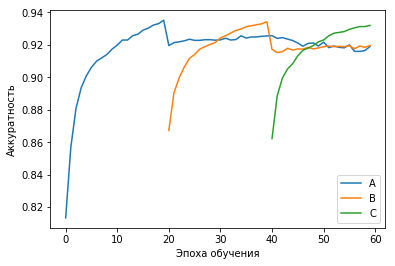

In [16]:
order_all = np.random.permutation(img_line)
tr_c = X_train[:,order_all]
ts_c = X_test[:,order_all]

score_c = np.zeros((num_epoch,2))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_c, Y_train, batch_size=bsize, epochs=1, verbose=0)
    score = model.evaluate(ts_a, Y_test, verbose=0)
    score_a[epoch+num_epoch*2,:] = [epoch+num_epoch*2,score[1]]
    score = model.evaluate(ts_b, Y_test, verbose=0)
    score_b[epoch+num_epoch,:] = [epoch+num_epoch*2,score[1]]
    score = model.evaluate(ts_c, Y_test, verbose=0)
    score_c[epoch,:] = [epoch+num_epoch*2,score[1]]
    pbar.update(epoch+1)
pbar.finish()

plt.plot(score_a[:,0],score_a[:,1],label='A')
plt.plot(score_b[:,0],score_b[:,1],label='B')
plt.plot(score_c[:,0],score_c[:,1],label='C')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Save training trends if necessary
#np.savez('EWC_9',score_a=score_a,score_b=score_b,score_c=score_c)